# Projekt 3
Rozpoznawanie liczb za pomocą współczynników mel-cepstralnych (MFCC)

In [1]:
import os

import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

from modules.predictApp import PredictApp
from modules.window import Window

## Próba własnej implementacji MFCC

In [2]:
directory = f"./samples/liczby/"
file_name = os.listdir(directory)[0]
predictApp = PredictApp(os.path.join(directory, file_name))

In [3]:
FFT_size = 2048

audio_framed_ffr = predictApp.frame_audio_ffr(predictApp.samples)
window = Window.get_window("hann", FFT_size)
audio_windowed = audio_framed_ffr * window
predictApp.window_plot(audio_framed_ffr, audio_windowed, 2)

In [4]:
sample_rate = 22050
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

filter_points, mel_freqs = predictApp.get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate)
filters = predictApp.get_filters(filter_points, FFT_size)
predictApp.plot_filters(filters)

## Trenowanie modeli

### Przygotowanie ramki danych z wartościami MFCC za pomocą biblioteki `librosa`

In [5]:
extracted_features_df = predictApp.extract_features_from_directory()

X = np.stack(extracted_features_df["feature"].values)
y = extracted_features_df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

100%|██████████| 96/96 [00:01<00:00, 55.48it/s]


### Model - `XGBClassifier`

----------------------------------------Zbiór treningowy----------------------------------------
               0      1      2      3      4      5      6      7      8      9     10  accuracy
precision  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000     1.000
recall     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000     1.000
f1-score   1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000     1.000

-----------------------------------------Zbiór testowy------------------------------------------
               0      1      2      3      4      5      6      7      8      9     10  accuracy
precision  1.000  0.750  0.500  0.333  0.333  0.667  0.667  0.500  0.500  0.000  0.667     0.552
recall     0.500  1.000  0.667  0.500  0.333  1.000  0.667  0.333  0.333  0.000  0.667     0.552
f1-score   0.667  0.857  0.571  0.400  0.333  0.800  0.667  0.400  0.400  0.000  0.667     0.552



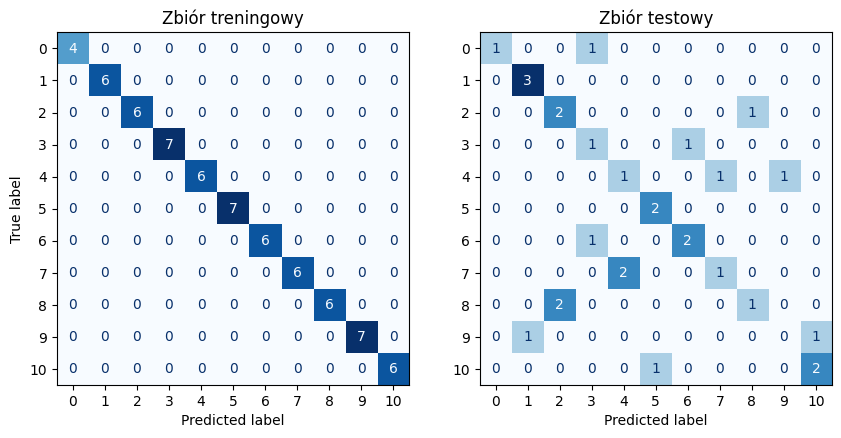

In [6]:
model = XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.5, booster='gbtree', gamma=0.5, random_state=0)

# trenowanie modelu
model.fit(X_train, y_train)

# wyniki
predictApp.print_precision_recall_report(model, X_train, y_train, X_test, y_test)

### Model - sieć nieuronowa

----------------------------------------Zbiór treningowy----------------------------------------
               0      1      2      3      4      5      6      7      8      9     10  accuracy
precision  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.800  0.714     0.955
recall     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.667  0.833     0.955
f1-score   1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000  0.727  0.769     0.955

-----------------------------------------Zbiór testowy------------------------------------------
               0      1      2      3      4      5      6      7      8      9     10  accuracy
precision  1.000  1.000  1.000  1.000  0.400  1.000  1.000  0.333  0.500  0.000  0.500     0.621
recall     1.000  0.667  0.500  0.667  0.667  0.667  0.500  0.333  1.000  0.000  1.000     0.621
f1-score   1.000  0.800  0.667  0.800  0.500  0.800  0.667  0.333  0.667  0.000  0.667     0.621



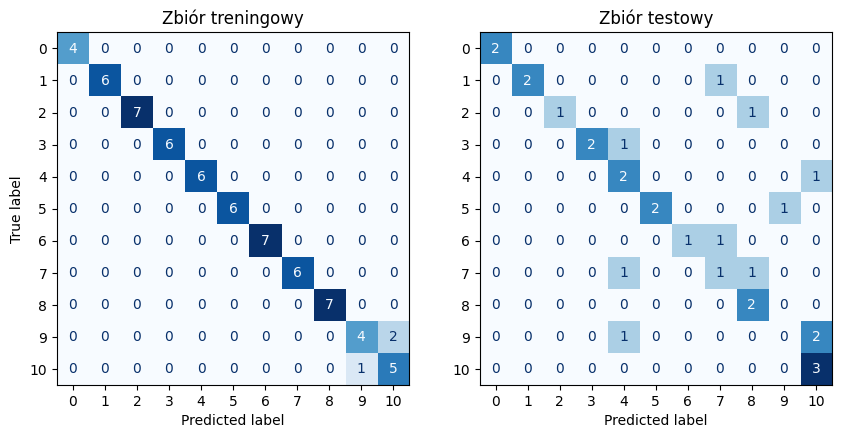

In [7]:
tensorflow.keras.utils.set_random_seed(1)

# kodowanie one-hot 'y'
labelencoder = LabelEncoder()
y_encoded = to_categorical(labelencoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0, stratify=y_encoded)

# tworzenie modelu
num_labels = y_encoded.shape[1]
model = Sequential()
model.add(Dense(30, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# trenowanie modelu
num_epochs = 200

model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=0)

# wyniki
predictApp.print_precision_recall_report(model, X_train, y_train, X_test, y_test, verbose=0)